# Quantile mapping

This notebook applies a quantile mapping approach to correct the bias of seasonal forecasts, in this case the ECMWF SEAS5 precipitation, temperature and evaporation ensembles. This approach corrects the statistical distribution (cumulative distribution function, CDF) of the forecast such that matches the one corresponding to the observations.

For each percentile, from the 1st to the 99th, a correction factor is estimated by calculating the difference between the hindcasts CDF and the observation CDF. For values lower or higher that the percentile range, the 1st and 99th percentiles correction factors are applied respectively.

The correction factors are estimated on a monthly basis (12 monthly correction functions x 99+ factors (1 per percentile) = 1188+ correction factors per year).

## Inputs

- obsr   = observed data [rain, temp, evap] - array [h,3]
- ctrl   = control or reference data
- tdates = daily dates. Suitable formats:
    - [dd,mm,yyyy] - array [h,3]
    - date - array [h,1]
    - day since 01/01/1900 - array [h,1]
    
## Outputs
- perc_obsr = CDF of the observed data
- perc_ctrl = CDF of the control/reference data

## 1. Import general libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
sns.set()

from Submodules.Climatology_data import Climatology_data

## 2. Initial options

In [2]:
provider = 'ECMWF' # seasonal forecast provider
year     = 2016    # year
month    = 2      # month
day      = 1       # day
#horizon  = 5       # lead time in weeks
date = datetime.datetime(year,month,day)

## 3. Load data and define bias correction
### 3.1 Forecast data

In [3]:
from netCDF4 import Dataset

data_fore = Dataset(provider+"//"+str(year)+str(month).zfill(2)+str(1).zfill(2)+"_1d_7m_"+provider+"_Temp_Evap_Rain.nc", "r")
dates_fore = pd.to_datetime(data_fore['time'][:]-24, unit='h',origin = pd.Timestamp('01-01-1900'))
# the next day at 00:00 we need to substract one day (-24h) to reflect that the first data member corresponds to the first 
# day and not to the next day at 00:00

# Temperature
T_fore=data_fore.variables['t2m'][:] # in degK
T_fore_ens = T_fore.mean(3).mean(2)-273.15 # in degC

# Evaporation
E_fore=data_fore.variables['e'][:]*1000
E_fore_cum = -E_fore.mean(3).mean(2)  # in mm 
E_fore_ens = np.zeros(np.shape(E_fore_cum))
for i in np.arange(len(E_fore_cum[0,:])):
    for j in np.arange(len(E_fore_cum[:,0])-1):
        E_fore_ens[j+1,i] = np.maximum(E_fore_cum[j+1,i]-E_fore_cum[j,i],0)
        
# Precipitation
P_fore=data_fore.variables['tp'][:]*1000
P_fore_cum = P_fore.mean(3).mean(2)  # in mm 
P_fore_ens = np.zeros(np.shape(P_fore_cum))
for i in np.arange(len(P_fore_cum[0,:])):
    for j in np.arange(len(P_fore_cum[:,0])-1):
        P_fore_ens[j+1,i] = np.maximum(P_fore_cum[j+1,i]-P_fore_cum[j,i],0)

# number of months covered by the forecast
if month>dates_fore[-1].month:
    num_months = dates_fore[-1].month - month + 1 + 12
else:
    num_months = dates_fore[-1].month - month + 1

### 3.2 Observed data 

In [5]:
data_obsr = 'Data//ClimdataWim.csv'

dates_obsr = pd.to_datetime(np.genfromtxt(data_obsr, delimiter = ',',skip_header=1,usecols=0,dtype='str'), format = '%d/%m/%Y')
weather_data_obsr = np.genfromtxt(data_obsr, delimiter = ',',skip_header=1)
PET = weather_data_obsr[0:,1]
Rain = weather_data_obsr[0:,2]
Temp = weather_data_obsr[0:,3]

ydays = np.zeros(len(dates_fore))
for i in range(len(dates_fore)):
    ydays[i] = int(dates_fore[i].timetuple().tm_yday)

Rain_obs_mat,I_obs_mat = Climatology_data(28.8,'daily')

# Historical weekly rain and inflow ensembles (from 1968 till year of study -1)
Rain_clim_ens = np.zeros([len(ydays),np.shape(Rain_obs_mat[:,Rain_obs_mat[0,:]<year])[1]])
I_clim_ens = np.zeros([len(ydays),np.shape(I_obs_mat[:,I_obs_mat[0,:]<year])[1]])
for i in range(len(ydays)):
    Rain_clim_ens[i,:] = Rain_obs_mat[int(ydays[i]),Rain_obs_mat[0,:]<year]
    I_clim_ens[i,:] = I_obs_mat[int(ydays[i]),I_obs_mat[0,:]<year]

### 3.3 Load control data (ECMWF seasonal hindcasts) and forecast bias correction

In [6]:
num_mem = 25
Prc = np.arange(1,100)

T_fore_corr= np.zeros(np.shape(T_fore_ens))
E_fore_corr= np.zeros(np.shape(E_fore_ens))
P_fore_corr= np.zeros(np.shape(P_fore_ens))

for i in np.arange(0,num_months):
    if month+i<=12:
        m = month+i
    else:
        m = month+i-12
    T_ctrl_all = []
    E_ctrl_all = []
    P_ctrl_all = []
    
    # Observed data
    ID_obsr = np.where((dates_obsr.year>=1981) & (dates_obsr.year<year) & (dates_obsr.month==m))[0]
    
    T_obsr = Temp[ID_obsr]
    T_obsr_prc = np.percentile(T_obsr,Prc) 
    
    E_obsr = PET[ID_obsr]
    E_obsr_prc = np.percentile(E_obsr,Prc)
    
    P_obsr = Rain[ID_obsr]
    P_obsr_prc = np.percentile(P_obsr,Prc)
    
    for y in np.arange(1981,year):

        #Control/reference data
        data_ctrl = Dataset(provider+"//"+str(y)+str(month).zfill(2)+str(1).zfill(2)+"_1d_7m_"+provider+"_Temp_Evap_Rain.nc", "r")

        dates_ctrl = pd.to_datetime(data_ctrl['time'][:]-24, unit='h',origin = pd.Timestamp('1900-01-01'))
        # the data is given every 24 h, so the it always starts the next day at 00:00 we need to substract 
        # one day (-24h) to reflect that the first data member corresponds to the first day and not to the next day at 00:00

        ID_ctrl = np.where((dates_ctrl.year>=1981) & (dates_ctrl.month==m))[0]

        # Temperature
        T_ctrl=data_ctrl.variables['t2m'][:] # in degK
        T_ctrl_ens = T_ctrl.mean(3).mean(2)-273.15 # in degC
        T_ctrl_all = np.append(T_ctrl_all,np.reshape(T_ctrl_ens[ID_ctrl,0:num_mem],[np.size(T_ctrl_ens[ID_ctrl,0:num_mem]),1]))
        T_ctrl_prc = np.percentile(T_ctrl_all,Prc) 
        
        # Evaporation
        E_ctrl=data_ctrl.variables['e'][:]*1000
        E_ctrl_cum = -E_ctrl.mean(3).mean(2)  # in mm 
        E_ctrl_ens = np.zeros(np.shape(E_ctrl_cum))
        for i in np.arange(len(E_ctrl_cum[0,:])):
            for j in np.arange(len(E_ctrl_cum[:,0])-1):
                E_ctrl_ens[j+1,i] = np.maximum(E_ctrl_cum[j+1,i]-E_ctrl_cum[j,i],0)
        E_ctrl_all = np.append(E_ctrl_all,np.reshape(E_ctrl_ens[ID_ctrl,0:num_mem],[np.size(E_ctrl_ens[ID_ctrl,0:num_mem]),1]))
        E_ctrl_prc = np.percentile(E_ctrl_all,Prc) 
        
        # Precipitation
        P_ctrl=data_ctrl.variables['tp'][:]*1000
        P_ctrl_cum = P_ctrl.mean(3).mean(2) # in mm 
        P_ctrl_ens = np.zeros(np.shape(P_ctrl_cum))
        for i in np.arange(len(P_ctrl_cum[0,:])):
            for j in np.arange(len(P_ctrl_cum[:,0])-1):
                P_ctrl_ens[j+1,i] = np.maximum(P_ctrl_cum[j+1,i]-P_ctrl_cum[j,i],0)
        P_ctrl_all = np.append(P_ctrl_all,np.reshape(P_ctrl_ens[ID_ctrl,0:num_mem],[np.size(P_ctrl_ens[ID_ctrl,0:num_mem]),1]))
        P_ctrl_prc = np.percentile(P_ctrl_all,Prc)
        
    # Outside the table range (< 1 prc or > 99 prc), a constant correction is applied
    T_ctrl_min = np.min( T_ctrl_prc )                       
    T_ctrl_max = np.max( T_ctrl_prc )                       
    T_ctrl_inf = [-50]
    T_ctrl_sup = [50]
    T_ctrl_prc = np.append(T_ctrl_inf,T_ctrl_prc)    
    T_ctrl_prc = np.append(T_ctrl_prc,T_ctrl_sup)
    # the values of Prc_ctrl should be distinct, if they are not (e.g. dry climate) an eps will be added.
    T_ctrl_prc[np.where(np.diff(T_ctrl_prc) == 0)[0]+1] = T_ctrl_prc[np.where(np.diff(T_ctrl_prc) == 0)] + np.finfo(float).eps * np.random.randn(np.size(T_ctrl_prc[np.where(np.diff(T_ctrl_prc) == 0)]))
    
    E_ctrl_min = np.min( E_ctrl_prc )                       
    E_ctrl_max = np.max( E_ctrl_prc )                       
    E_ctrl_inf = [0]
    E_ctrl_sup = [300]
    E_ctrl_prc = np.append(E_ctrl_inf,E_ctrl_prc)    
    E_ctrl_prc = np.append(E_ctrl_prc,E_ctrl_sup) 
    # the values of Prc_ctrl should be distinct, if they are not (e.g. dry climate) an eps will be added.
    E_ctrl_prc[np.where(np.diff(E_ctrl_prc) == 0)[0]+1] = E_ctrl_prc[np.where(np.diff(E_ctrl_prc) == 0)] + np.finfo(float).eps * np.random.randn(np.size(E_ctrl_prc[np.where(np.diff(E_ctrl_prc) == 0)]))
    
    P_ctrl_min = np.min( P_ctrl_prc )                       
    P_ctrl_max = np.max( P_ctrl_prc )                       
    P_ctrl_inf = [0]
    P_ctrl_sup = [300]
    P_ctrl_prc = np.append(P_ctrl_inf,P_ctrl_prc)    
    P_ctrl_prc = np.append(P_ctrl_prc,P_ctrl_sup) 
    # the values of Prc_ctrl should be distinct, if they are not (e.g. dry climate) an eps will be added.
    P_ctrl_prc[np.where(np.diff(P_ctrl_prc) == 0)[0]+1] = P_ctrl_prc[np.where(np.diff(P_ctrl_prc) == 0)] + np.finfo(float).eps * np.random.randn(np.size(P_ctrl_prc[np.where(np.diff(P_ctrl_prc) == 0)]))
    
    T_obsr_min = np.min( T_obsr_prc )                       
    T_obsr_max = np.max( T_obsr_prc )                       
    T_obsr_inf = T_ctrl_inf + (T_obsr_min - T_ctrl_min)
    T_obsr_sup = T_ctrl_sup + (T_obsr_min - T_ctrl_min)
    T_obsr_prc = np.append(T_obsr_inf,T_obsr_prc)    
    T_obsr_prc = np.append(T_obsr_prc,T_obsr_sup)
    
    E_obsr_min = np.min( E_obsr_prc )                       
    E_obsr_max = np.max( E_obsr_prc )                       
    E_obsr_inf = E_ctrl_inf + (E_obsr_min - E_ctrl_min)
    E_obsr_inf[np.where(E_obsr_inf<0)] = 0
    E_obsr_sup = E_ctrl_sup + (E_obsr_min - E_ctrl_min)
    E_obsr_prc = np.append(E_obsr_inf,E_obsr_prc)    
    E_obsr_prc = np.append(E_obsr_prc,E_obsr_sup)
    
    P_obsr_min = np.min( P_obsr_prc )                       
    P_obsr_max = np.max( P_obsr_prc )                       
    P_obsr_inf = P_ctrl_inf + (P_obsr_min - P_ctrl_min)
    P_obsr_inf[np.where(P_obsr_inf<0)] = 0
    P_obsr_sup = P_ctrl_sup + (P_obsr_min - P_ctrl_min)
    P_obsr_prc = np.append(P_obsr_inf,P_obsr_prc)    
    P_obsr_prc = np.append(P_obsr_prc,P_obsr_sup)
    
    # Define the forecast data each month
    ID_scen = np.where((dates_fore.year>=1981) & (dates_fore.month==m))[0]
    T_scen = T_fore_ens[ID_scen,0:num_mem]
    E_scen = E_fore_ens[ID_scen,0:num_mem]
    P_scen = P_fore_ens[ID_scen,0:num_mem]
    
    T_scen_corr = np.interp(T_scen,T_ctrl_prc,T_obsr_prc)
    T_fore_corr[ID_scen,0:num_mem] = T_scen_corr
    
    E_scen_corr = np.interp(E_scen,E_ctrl_prc,E_obsr_prc)
    E_fore_corr[ID_scen,0:num_mem] = E_scen_corr
    
    P_scen_corr = np.interp(P_scen,P_ctrl_prc,P_obsr_prc)
    P_fore_corr[ID_scen,0:num_mem] = P_scen_corr

## 4. Plot results

### 4.1 Temperature

<function matplotlib.pyplot.show>

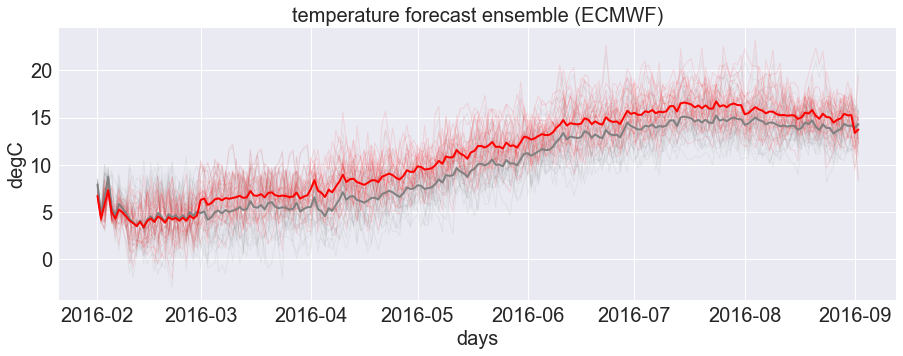

In [7]:
fig,ax0 = plt.subplots(figsize=(15, 5))
ax0.plot(dates_fore,T_fore_ens,'grey',alpha=0.1,linewidth=1)
#ax0.plot(dates_fore,T_ctrl_ens,'blue',alpha=0.1,linewidth=1)
ax0.plot(dates_fore,T_fore_corr,'red',alpha=0.1,linewidth=1)
ax0.plot(dates_fore,np.mean(T_fore_ens,axis=1),'grey',alpha=1,linewidth=2)
#ax0.plot(dates_fore,np.mean(T_ctrl_ens,axis=1),'blue',alpha=1,linewidth=2)
ax0.plot(dates_fore,np.mean(T_fore_corr,axis=1),'red',alpha=1,linewidth=2)
ax0.set_xlabel('days', fontsize = 20)
ax0.set_ylabel('degC', fontsize = 20)
for label in (ax0.get_xticklabels() + ax0.get_yticklabels()):
    label.set_fontsize(20)
ax0.set_title('temperature forecast ensemble (ECMWF)', fontsize = 20)
#ax0.set_xlim([1,30])
plt.show

### 4.2 PET

<function matplotlib.pyplot.show>

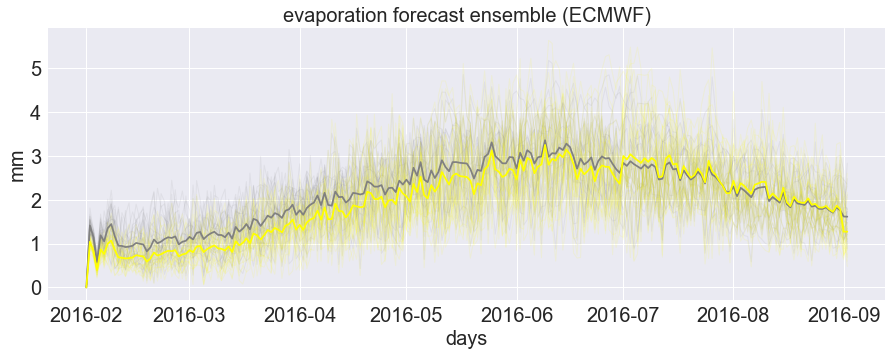

In [8]:
fig,ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(dates_fore,E_fore_ens,'grey',alpha=0.1,linewidth=1)
ax1.plot(dates_fore,E_fore_corr,'yellow',alpha=0.1,linewidth=1)
ax1.plot(dates_fore,np.mean(E_fore_ens,axis=1),'grey',alpha=1)
ax1.plot(dates_fore,np.mean(E_fore_corr,axis=1),'yellow',alpha=1)
ax1.set_xlabel('days', fontsize = 20)
ax1.set_ylabel('mm', fontsize = 20)
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontsize(20)
ax1.set_title('evaporation forecast ensemble (ECMWF)', fontsize = 20)
plt.show

### 4.3 Precipitation

<function matplotlib.pyplot.show>

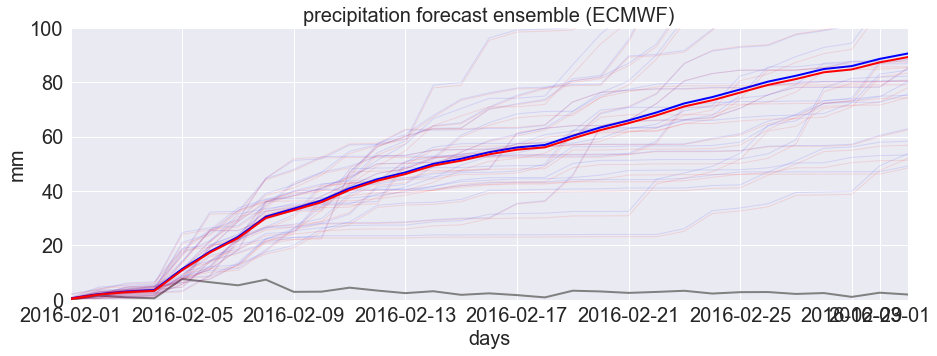

In [11]:
fig,ax2 = plt.subplots(figsize=(15, 5))
ax2.plot(dates_fore,np.mean(P_fore_ens,axis=1),'grey',alpha=1,linewidth=2)
ax2.plot(dates_fore,P_fore.mean(2)[:,:,0],'blue',alpha=0.1,linewidth=1)
ax2.plot(dates_fore,np.mean(P_fore.mean(2)[:,:,0],axis=1),'blue',alpha=1,linewidth=2)
ax2.plot(dates_fore,P_fore.mean(2)[:,:,1],'red',alpha=0.1,linewidth=1)
ax2.plot(dates_fore,np.mean(P_fore.mean(2)[:,:,1],axis=1),'red',alpha=1,linewidth=2)
ax2.set_xlabel('days', fontsize = 20)
ax2.set_ylabel('mm', fontsize = 20)
for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontsize(20)
ax2.set_title('precipitation forecast ensemble (ECMWF)', fontsize = 20)
ax2.set_ylim([0,100])
ax2.set_xlim(dates_fore[0],dates_fore[30])
plt.show

<function matplotlib.pyplot.show>

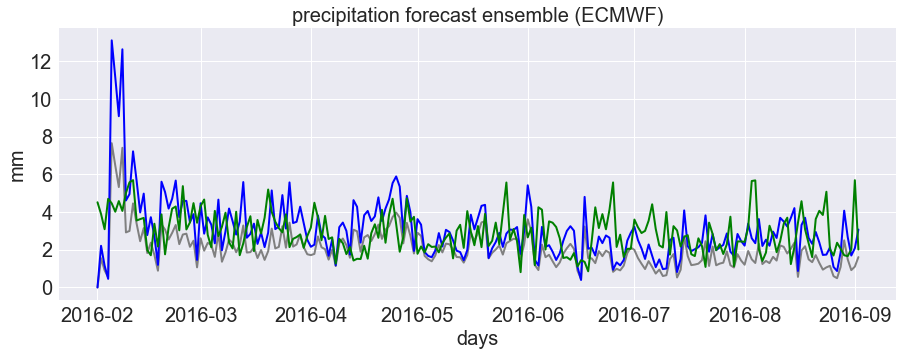

In [12]:
fig,ax2 = plt.subplots(figsize=(15, 5))
#ax2.plot(dates_fore,P_fore_ens,'grey',alpha=0.1,linewidth=1)
#ax2.plot(dates_fore,P_fore_corr,'blue',alpha=0.1,linewidth=1)
ax2.plot(dates_fore,np.mean(P_fore_ens,axis=1),'grey',alpha=1,linewidth=2)
ax2.plot(dates_fore,np.mean(P_fore_corr,axis=1),'blue',alpha=1,linewidth=2)
ax2.plot(dates_fore,np.mean(Rain_clim_ens,axis=1),'green',alpha=1,linewidth=2)
ax2.set_xlabel('days', fontsize = 20)
ax2.set_ylabel('mm', fontsize = 20)
for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontsize(20)
ax2.set_title('precipitation forecast ensemble (ECMWF)', fontsize = 20)
#ax2.set_xlim(dates_fore[0],dates_fore[30])
plt.show

## 5. Save bias corrected data to a file (.npy)

In [20]:
data_fore_bc = np.zeros([np.shape(T_fore_corr)[0],np.shape(T_fore_corr)[1],4])*np.nan
data_fore_bc[:,0,0] = data_fore['time'][:]-24
data_fore_bc[:,:,1] = T_fore_corr
data_fore_bc[:,:,2] = E_fore_corr
data_fore_bc[:,:,3] = P_fore_corr
np.save(provider+"//Bias corrected - QM//"+str(year)+str(month).zfill(2)+str(1).zfill(2)+"_1d_7m_"+provider+"_Temp_Evap_Rain",data_fore_bc)